[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ASKabalan/jax-hpc-profiler/blob/main/examples/distributed_profiling.ipynb)

### **Distributed Profiling with JAX HPC Profiler**

This notebook demonstrates how to use the `jax_hpc_profiler` package for distributed profiling in a multi-device setup. By utilizing environment variables to configure JAX for multi-device execution, we can simulate distributed environments and gather performance data for analysis. The notebook walks through setting up profiling for large-scale computations, capturing performance metrics, and generating visualizations for scalability analysis.

In [ ]:
try:
    import google.colab

    !pip install -q jax-hpc-profiler 
except ImportError:
    pass  # Not in Colab

In [9]:
import os

os.environ['JAX_PLATFORM_NAME'] = 'cpu'
os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=32'
import jax
import jax.numpy as jnp

from jax_hpc_profiler import Timer

OUTPUT_PATH = 'jax_hpc_profiler_report'

In this section, a JAX function mma is defined to perform matrix multiplication and addition, optimized using the JIT compiler.

In [10]:
# Define JAX functions
@jax.jit
def mma(m, n, k):
    return jnp.dot(m, n) + k

### **Distributed Profiling with Multiple Devices**

This section demonstrates profiling on multiple devices (using 4, 8, 16, and 32 devices) in a distributed JAX setup, where matrices are sharded across the devices for parallel computation. The performance is then measured and reported for different matrix sizes.

In [11]:
from jax import lax
from jax.sharding import AxisType, NamedSharding
from jax.sharding import PartitionSpec as P

for n_devices in [4, 8, 16, 32]:
    devices = jax.devices()[:n_devices]
    timer = Timer(devices=devices)
    mesh = jax.make_mesh((len(devices),), ('x',), devices=devices, axis_types=(AxisType.Auto,))
    sharding = NamedSharding(mesh, P('x'))

    for size in [128, 256, 512, 1024]:
        # JAX Matrices
        m_jax = jnp.ones((size, size))
        n_jax = jnp.ones((size, size))
        k_jax = jnp.ones((size, size))

        # JAX Sharded Matrices
        m_jax = lax.with_sharding_constraint(m_jax, sharding)
        n_jax = lax.with_sharding_constraint(n_jax, sharding)
        k_jax = lax.with_sharding_constraint(k_jax, sharding)

        timer.chrono_jit(mma, m_jax, n_jax, k_jax)
        for _ in range(10):
            timer.chrono_fun(mma, m_jax, n_jax, k_jax)

        kwargs = {
            'function': 'mma',
            'precision': 'float32',
            'x': size,
            'y': size,
            'px': n_devices,
            'py': 1,
        }
        extra_info = {'done': 'yes'}
        timer.report(f'{OUTPUT_PATH}/JAX_MULTI.csv', **kwargs, extra_info=extra_info)

### **Visualizing Weak, WeakFixed, and Strong Scaling**

This section uses multi-device results in `JAX_MULTI.csv` to create three plots:
- **WeakFixed**: size scaling at fixed GPU counts.
- **Strong**: fixed problem size(s), varying GPUs.
- **Weak**: true weak scaling with explicit `(gpus, data_size)` pairs; a second plot shows reversed axes to view runtime vs data size while annotating GPU counts.


In [12]:
import os
import sys

import matplotlib.pyplot as plt
import seaborn as sns

for rel in ('src', os.path.join('..', 'src')):
    path = os.path.abspath(rel)
    if os.path.isdir(path) and path not in sys.path:
        sys.path.insert(0, path)

from jax_hpc_profiler.plotting import (
    plot_strong_scaling,
    plot_weak_fixed_scaling,
    plot_weak_scaling,
)

plt.rcParams.update({'font.size': 15})
sns.set_context('talk')

csv_file = [f'{OUTPUT_PATH}/JAX_MULTI.csv']

#### Weak Fixed Scaling

Weak fixed scaling measures how runtime changes as the **problem size increases** while keeping the **number of GPUs constant**. This helps understand the computational overhead and memory bandwidth limitations at different scales. Ideally, runtime should increase proportionally with problem size.

requested GPUS: None available GPUS: {np.int64(8), np.int64(16), np.int64(32), np.int64(4)}
requested data sizes: None available data sizes: {np.int64(128), np.int64(256), np.int64(512), np.int64(1024)}


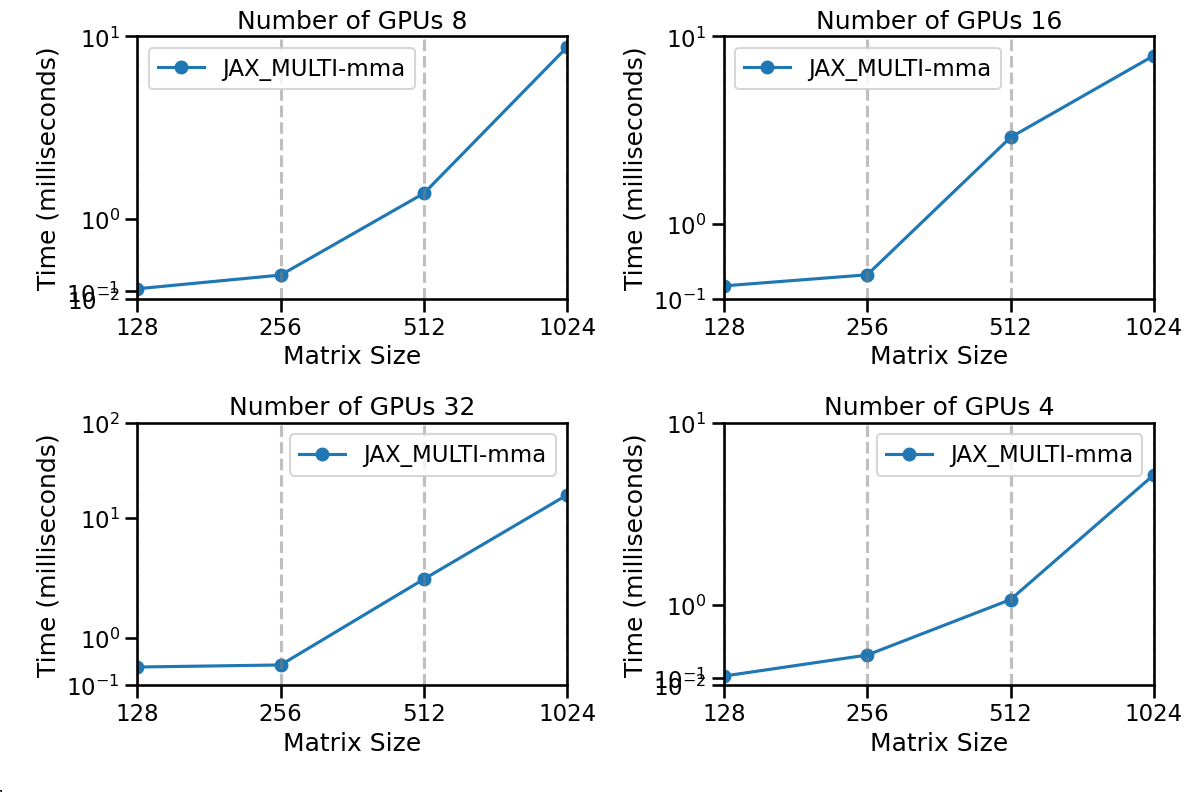

In [13]:
plot_weak_fixed_scaling(
    csv_files=csv_file,
    figure_size=(12, 8),
    label_text='%m%-%f%',
    xlabel='Matrix Size',
)

#### Strong Scaling

Strong scaling measures how runtime decreases when **adding more GPUs** to a **fixed problem size**. This reveals parallelization efficiency—ideal strong scaling would show runtime halving when doubling the number of GPUs. Deviations indicate communication overhead or load imbalance.

requested GPUS: None available GPUS: {np.int64(8), np.int64(16), np.int64(32), np.int64(4)}
requested data sizes: None available data sizes: {np.int64(128), np.int64(256), np.int64(512), np.int64(1024)}


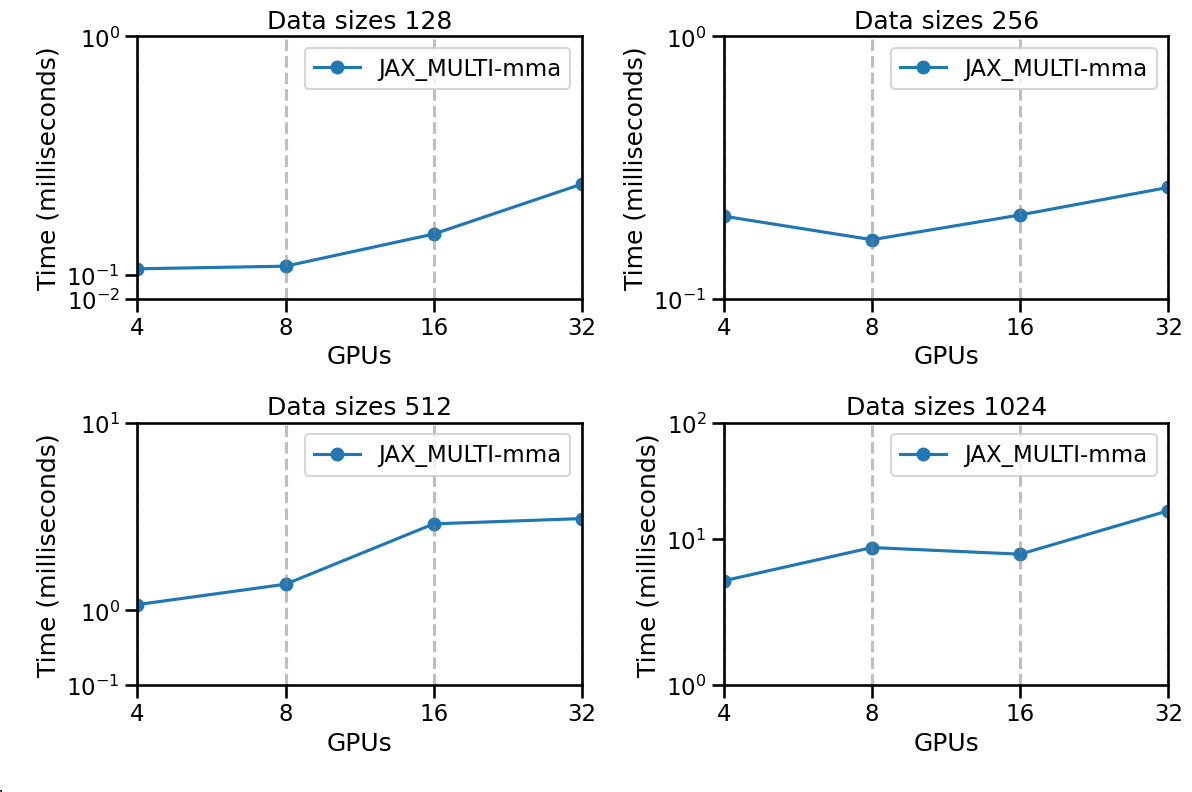

In [14]:
plot_strong_scaling(
    csv_files=csv_file,
    figure_size=(12, 8),
    label_text='%m%-%f%',
    xlabel='GPUs',
)

#### Weak Scaling

Weak scaling measures runtime when the **problem size per GPU remains constant** as GPUs are added (i.e., total problem size grows proportionally with GPU count). The ideal line shows perfect weak scaling where runtime stays constant. Deviations above the ideal line indicate communication or synchronization overhead.

requested GPUS: [4, 8, 16, 32] available GPUS: {np.int64(8), np.int64(16), np.int64(32), np.int64(4)}
requested data sizes: [128, 256, 512, 1024] available data sizes: {np.int64(128), np.int64(256), np.int64(512), np.int64(1024)}


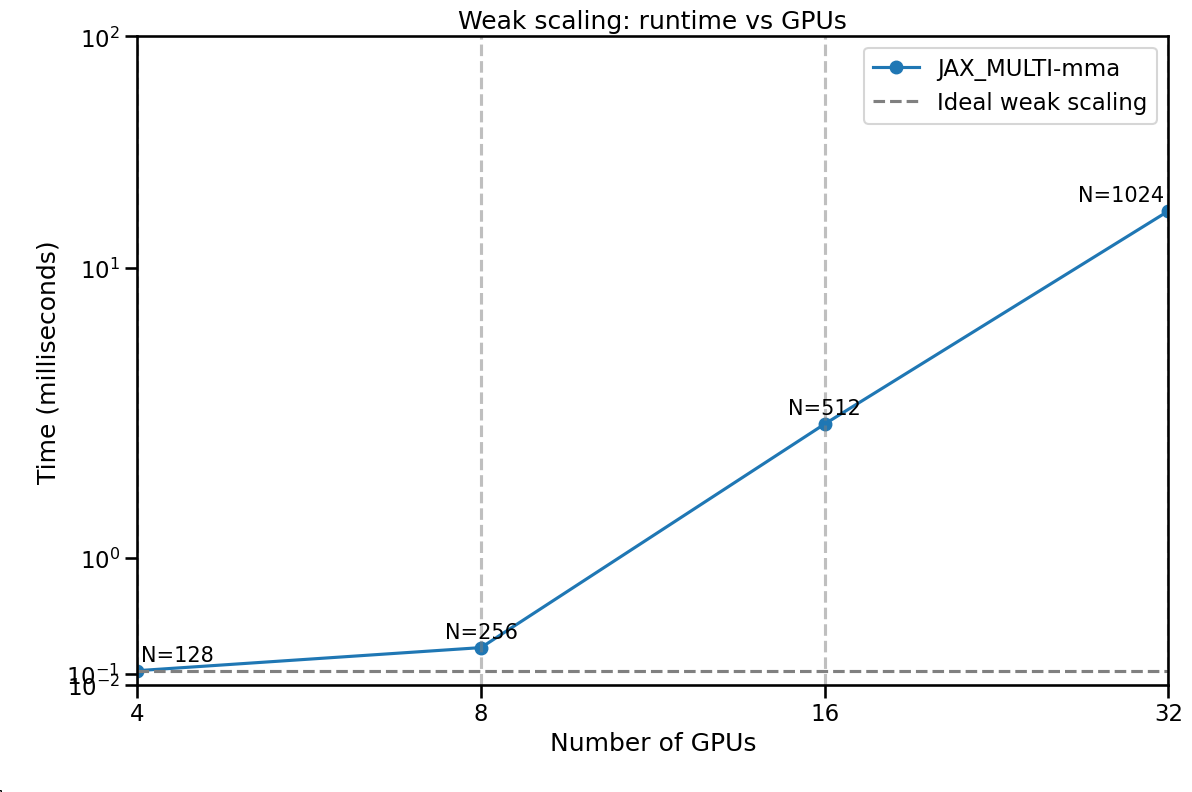

In [15]:
plot_weak_scaling(
    csv_files=csv_file,
    fixed_gpu_size=[4, 8, 16, 32],
    fixed_data_size=[128, 256, 512, 1024],
    figure_size=(12, 8),
    label_text='%m%-%f%',
    ideal_line=True,
    reverse_axes=False,
    xlabel='Number of GPUs',
    title='Weak scaling: runtime vs GPUs',
)

#### Weak Scaling (Reversed Axes)

This is the same weak scaling data but with **axes reversed**: runtime is plotted against **data size** instead of GPU count, with GPU counts shown as annotations. This view helps visualize how problem size affects performance while tracking which GPU configuration was used for each data point.

requested GPUS: [4, 8, 16, 32] available GPUS: {np.int64(8), np.int64(16), np.int64(32), np.int64(4)}
requested data sizes: [128, 256, 512, 1024] available data sizes: {np.int64(128), np.int64(256), np.int64(512), np.int64(1024)}


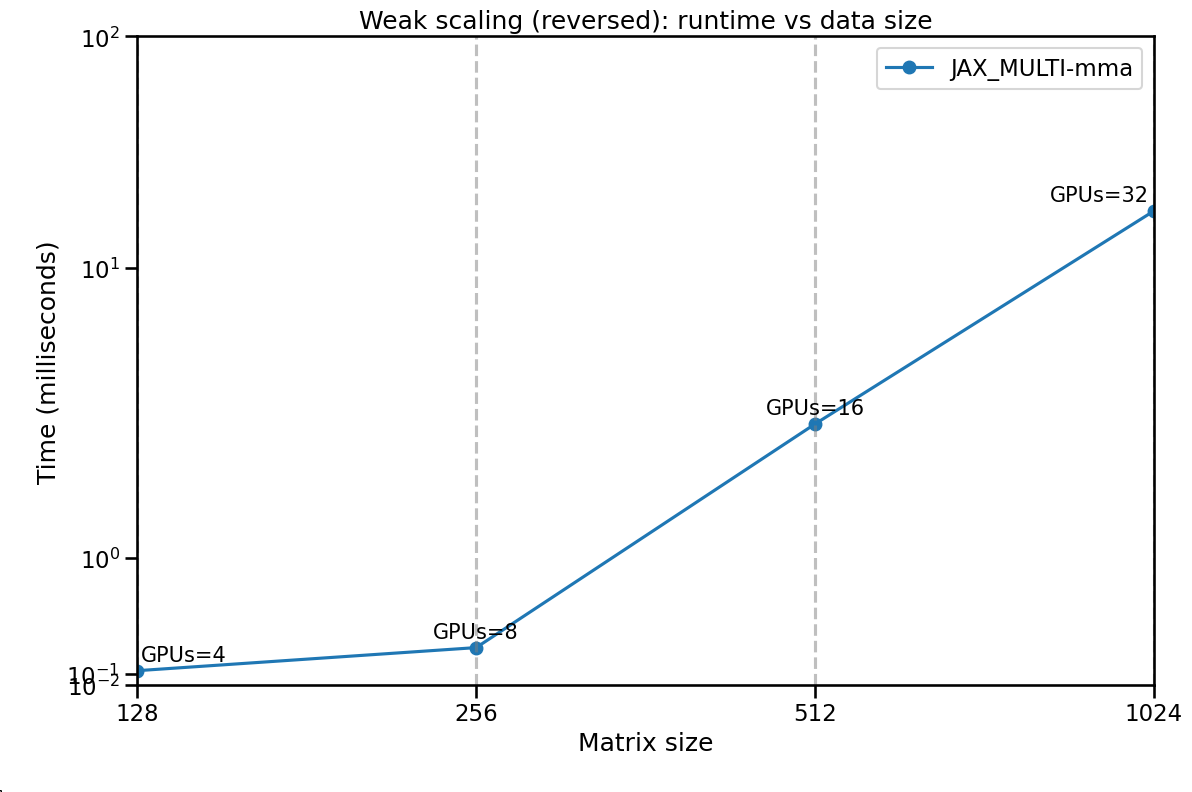

In [16]:
plot_weak_scaling(
    csv_files=csv_file,
    fixed_gpu_size=[4, 8, 16, 32],
    fixed_data_size=[128, 256, 512, 1024],
    figure_size=(12, 8),
    label_text='%m%-%f%',
    ideal_line=False,
    reverse_axes=True,
    xlabel='Matrix size',
    title='Weak scaling (reversed): runtime vs data size',
)

### **CLI examples for Weak scaling**

Use `jhp plot` with matching `(gpus, data_size)` lists.

- Runtime vs GPUs with ideal line and data-size annotations:

```bash
!jhp plot -f JAX_MULTI.csv -sc Weak -g 4 8 16 32 -d 128 256 512 1024 -pt mean_time --weak_ideal_line
```

- Runtime vs data size with reversed axes (annotations show GPUs):

```bash
!jhp plot -f JAX_MULTI.csv -sc Weak -g 4 8 16 32 -d 128 256 512 1024 -pt mean_time --weak_reverse_axes
```
